This is an example usage of a convolutional neural network constructed solely with components of this machine learning library project.
 
A neural network with plain batch gradient descent will be used to tackle the classic MNIST number classification problem. With this approach, a classification accuracy of 95.1% was achieved on the test set.

In [14]:
# Importing features of this machine learning library
from nn.BaseModel import BaseModel
from nn.layers import Linear, Conv2D, MaxPool2D
from nn.activations import Sigmoid, ReLu
from nn.loss_functions import BCE_loss
from nn.optimizers import GDOptimizer
from utils.preprocessing import train_test_split

# Importin other libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

Defining the convolutional neural network.

In [15]:
class CNN(BaseModel):
    def __init__(self):
        super().__init__()

        # Defining the layers of the model
        self.conv1 = Conv2D(1, 16, 3, 1)
        self.relu1 = ReLu()
        self.pool1 = MaxPool2D(2, 2)

        self.conv2 = Conv2D(16, 32, 3, 2)
        self.relu2 = ReLu()
        self.pool2 = MaxPool2D(2, 2)

        self.fc1 = Linear(3*3*32, 128)
        self.relu3 = ReLu()
        self.fc2 = Linear(128, 10)
        self.sigmoid = Sigmoid()

        self.add_layer(self.conv1)
        self.add_layer(self.conv2)
        self.add_layer(self.fc1)
        self.add_layer(self.fc2)

    def forward(self, x):
        x = self.conv1.forward(x)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)

        x = self.conv2.forward(x)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)  # dim (batch_size, 32, 3, 3)

        x = x.reshape(x.shape[0], -1)
        x = self.fc1.forward(x)
        x = self.relu3.forward(x)
        x = self.fc2.forward(x)
        x = self.sigmoid.forward(x)
        return x
    
    def backward(self, dy):
        dy = self.sigmoid.backward(dy)
        dy = self.fc2.backward(dy)
        dy = self.relu3.backward(dy)
        dy = self.fc1.backward(dy)

        dy = dy.reshape(-1, 32, 3, 3)
        dy = self.pool2.backward(dy)
        dy = self.relu2.backward(dy)
        dy = self.conv2.backward(dy)

        dy = self.pool1.backward(dy)
        dy = self.relu1.backward(dy)
        dy = self.conv1.backward(dy)
        return dy

Downloading the MNIST numbers dataset.

In [16]:
# Download the data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Normalize the images (28x28) to [0, 1]
X = X / 255

# Convert the labels to integers
y = y.astype(int)

# Convert the data into numpy arrays
X = np.array(X)
y = np.array(y)

In [17]:
# Convert y to target classes
y_new = np.zeros((y.shape[0], 10))
for i, target in enumerate(y):
    y_new[i, target] = 1
y = y_new

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


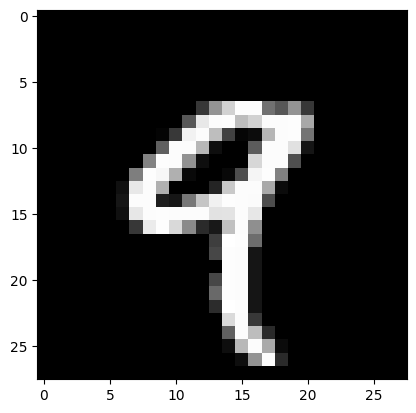

In [32]:
# Sanity check
image = 4
x_sample = X[image].reshape(28, 28)
y_sample = y[image]

print(y_sample)
plt.imshow(x_sample, 'gray')

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
X_train = X_train.reshape(-1, 1, 28, 28)
y_train = y_train.reshape(-1, 10)
print(X_train.shape, y_train.shape)

(56000, 1, 28, 28) (56000, 10)


In [21]:
# Take 30 percent of the training data due to computational constraints
X_train_reduced = X_train[:int(0.3 * X_train.shape[0])]
y_train_reduced = y_train[:int(0.3 * y_train.shape[0])]
print(X_train_reduced.shape, y_train_reduced.shape)

(16800, 1, 28, 28) (16800, 10)


Training the neural network.

In [22]:
learning_rate = 0.01
batch_size = 64

model = CNN()
optimizer = GDOptimizer(model, learning_rate)
loss_fn = BCE_loss()

# Training
epochs = 80
train_loss = []
num_batches = X_train_reduced.shape[0] // batch_size

for epoch in range(epochs):
    epoch_loss = []
    for i in range(num_batches):
        x_batch = X_train_reduced[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_reduced[i*batch_size:(i+1)*batch_size]

        y_pred = model.forward(x_batch)
        loss = loss_fn.forward(y_pred, y_batch)
        epoch_loss.append(loss)

        dy = loss_fn.backward()
        model.backward(dy)

        optimizer.update()

    train_loss.append(np.mean(epoch_loss))
    print(f'Epoch {epoch} Loss {train_loss[-1]}')


Epoch 0 Loss 0.3328952686735569
Epoch 1 Loss 0.2804409605584213
Epoch 2 Loss 0.24518675584849
Epoch 3 Loss 0.2123484582242699
Epoch 4 Loss 0.1851173239751845
Epoch 5 Loss 0.16416980372913922
Epoch 6 Loss 0.14807507268216272
Epoch 7 Loss 0.13541348955564392
Epoch 8 Loss 0.12524485436389876
Epoch 9 Loss 0.1169541501345887
Epoch 10 Loss 0.11006431097623343
Epoch 11 Loss 0.10421938739626381
Epoch 12 Loss 0.09915874471355109
Epoch 13 Loss 0.09472578080350993
Epoch 14 Loss 0.09082429269796766
Epoch 15 Loss 0.0873615925297454
Epoch 16 Loss 0.08425991649547372
Epoch 17 Loss 0.08144374089724021
Epoch 18 Loss 0.07887475312994491
Epoch 19 Loss 0.07651519081202966
Epoch 20 Loss 0.0743309110562086
Epoch 21 Loss 0.0723045511495174
Epoch 22 Loss 0.07041785299004177
Epoch 23 Loss 0.06865655335306747
Epoch 24 Loss 0.06700631160736743
Epoch 25 Loss 0.06545419350202736
Epoch 26 Loss 0.06399314503310352
Epoch 27 Loss 0.06261510439976119
Epoch 28 Loss 0.061305943244884586
Epoch 29 Loss 0.06006265843245749


Evaluating the model.

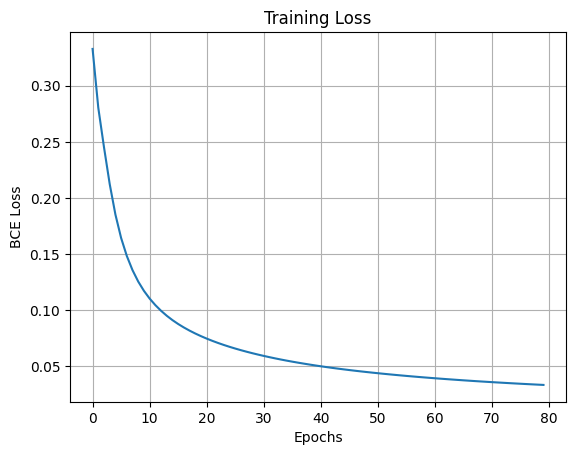

In [34]:
# Plot the training loss
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

In [35]:
X_test = X_test.reshape(-1, 1, 28, 28)
y_test = y_test.reshape(-1, 10)
print(y_pred.shape, y_test.shape)


(14000, 10) (14000, 10)


In [37]:
# Accuracy on the test set
y_pred = model.forward(X_test)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
print(f'Accuracy on the test set: {accuracy}')

Accuracy on the test set: 0.9510714285714286


In [25]:
# Accuracy on the train set
y_pred_train = model.forward(X_train_reduced)
accuracy_train = np.mean(np.argmax(y_pred_train, axis=1) == np.argmax(y_train_reduced, axis=1))
print(f'Accuracy on the train set: {accuracy_train}')


Accuracy on the train set: 0.9601785714285714


The neural network achieved an accuracy of 95.1% on the test set of the MNIST dataset, with no significant overfitting observed. The accuracy on the test set was 95.1%, compared to 96% on the training set.